# Instance creator utility

data  
|-->info  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->name  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->description  
|-->network  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->nodes  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        |-->node 0  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        .  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        .  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->info  
|-->requests  
|-->fleet  

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

In [2]:
def TSubElement(parent, tag, attrib={}, text=None, **extra):
    element = ET.SubElement(parent, tag, attrib, **extra)
    if text:
        element.text = text
    return element

### Network

In [3]:
def createInfo(root, name='', description=''):
    info = TSubElement(root, 'info')
    _name = TSubElement(info, 'name', text=name)
    _description = TSubElement(info, 'description', text=description)
    return

def createNetwork(root, numDepots, numCustomers, numChargeStations, 
                  cx_low=-1.0, cx_high=1.0, cy_low=-1.0, cy_high=1.0, 
                  request_min=0.01, request_max=0.8,
                  spent_time_min=2.0, spent_time_max=15.0,
                  tw_low_low=600.0, tw_low_high=960.0, tw_min_width= 20.0, tw_max_width=120.0, 
                  travel_time_min=3., travel_time_max=35., 
                  energy_consumption_min=2.0, energy_consumption_max=10.0,
                  max_capacity_charge_stations=4):
    
    network = TSubElement(root, 'network')
    nodes = TSubElement(network, 'nodes') # stores the nodes
    edges = TSubElement(network, 'edges') # stores edges
    info = TSubElement(network, 'info') # stores info about the network
    technologies = TSubElement(network, 'technologies') # stores info about CS techonologies
    
    # depot nodes
    for i in range(numDepots):
        attr = {'id': str(i), 'type': str(0)}
        node = TSubElement(nodes, 'node', attrib=attr)

    # customer nodes
    for i in range(i+1, i+numCustomers+1):
        attr = {'id': str(i), 'type': str(1)}
        node = TSubElement(nodes, 'node', attrib=attr)
        
        request = np.random.uniform(request_min, request_max)
        node.set('request', '{:.2f}'.format(request))
        
        spent_time = np.random.uniform(spent_time_min, spent_time_max)
        node.set('spent_time', '{:.2f}'.format(spent_time))
        
        tw_low = np.random.uniform(tw_low_low, tw_low_high)
        tw_upp = tw_low + np.random.uniform(tw_min_width, tw_max_width)
        node.set('tw_low', '{:.2f}'.format(tw_low))
        node.set('tw_upp', '{:.2f}'.format(tw_upp))

    # CS nodes
    for i in range(i+1, i+numChargeStations+1):
        attr = {'id': str(i), 'type': str(2)}
        node = TSubElement(nodes, 'node', attrib=attr)
        
        technology = np.random.randint(1, 4) # choose among 1, 2 and 3
        node.set('technology', str(technology))
        
        capacity = np.random.randint(1, max_capacity_charge_stations+1)
        node.set('capacity', str(capacity))
    
    # add coordinates (random)
    for node in nodes:
        cx = np.random.uniform(cx_low, cx_high)
        cy = np.random.uniform(cy_low, cy_high)
        node.set('cx', '{:.2f}'.format(cx))
        node.set('cy', '{:.2f}'.format(cy))
        
    # edges
    for i in nodes:
        nodeFrom = TSubElement(edges, 'node_from', attrib={'id': i.get('id')})
        for j in nodes:
            nodeTo = TSubElement(nodeFrom, 'node_to', attrib={'id': j.get('id')})
            
            if i == j:
                travelTime = 0.
                energyConsumption = 0.
            else:
                travelTime = np.random.uniform(travel_time_min, travel_time_max)
                energyConsumption = np.random.uniform(energy_consumption_min, energy_consumption_max)
                
            nodeTo.set('travel_time', '{:.2f}'.format(travelTime))
            nodeTo.set('energy_consumption', '{:.2f}'.format(energyConsumption))
            
    # technologies
    _tech1 = TSubElement(technologies, 'technology', attrib={'type': str(1)})
    _tech2 = TSubElement(technologies, 'technology', attrib={'type': str(2)})
    _tech3 = TSubElement(technologies, 'technology', attrib={'type': str(3)})
    
    tech1 = {'0.0': '0.0', '20.0': '75.0', '50.0': '80.0', '120.0': '100.0'}
    tech2 = {'0.0': '0.0', '15.0': '75.0', '40.0': '80.0', '80.0': '100.0'}
    tech3 = {'0.0': '0.0', '10.0': '75.0', '25.0': '80.0', '40.0': '100.0'}
    
    _tech_list = [_tech1, _tech2, _tech3]
    tech_list = [tech1, tech2, tech3]
    
    for _tech, tech in zip(_tech_list, tech_list):
        for chargingTime, battLevel in tech.items():
            breakPoint = TSubElement(_tech, 'breakpoint')
            breakPoint.set('charging_time', chargingTime)
            breakPoint.set('battery_level', battLevel)
    

### Fleet

In [10]:
def createFleet(root, fleet):
    _fleet = TSubElement(root, 'fleet')
    for ev_id, attrib in fleet.items():
        attrib['id'] = str(ev_id)
        _ev = TSubElement(_fleet, 'electric_vehicle', attrib=attrib)
    return


In [ ]:
def createTree(numDepots, numCustomers, numChargeStations, attribsEV):
    dataElement = ET.Element('instance')
    
    createInfo(dataElement)
    createNetwork(dataElement, numDepots, numCustomers, numChargeStations)
    fleetElement = createFleet(dataElement, attribsEV)
    
    return ET.ElementTree(dataElement)

In [12]:
numDepot = 1
numCustomer = 7
numCS = 2

numEV = 2
attrib = {'max_payload': '2.5', 
          'max_tour_duration': '250.0', 
          'battery_capacity': '220.0', 
          'alpha_down': '35.0', 'alpha_up':'85.0'}

evs ={x:attrib for x in range(numEV)}

dataTree = createTree(numDepot, numCustomer, numCS, evs)

{'max_payload': '2.5', 'max_tour_duration': '250.0', 'battery_capacity': '220.0', 'alpha_down': '35.0', 'alpha_up': '85.0', 'id': '0'}
{'max_payload': '2.5', 'max_tour_duration': '250.0', 'battery_capacity': '220.0', 'alpha_down': '35.0', 'alpha_up': '85.0', 'id': '1'}


In [13]:
#instanceName = 'd'+str(numDepot)+'c'+str(numCustomer)+'cs'+str(numCS)+'_ev'+str(numEV)
instanceName = 'test_instance'
folderPath = '../data/GA_implementation_xml/'+instanceName
filePath = folderPath+'/'+instanceName+'.xml'

try:
    os.mkdir(folderPath)
except FileExistsError:
    pass
print('Saving to:', filePath)

dataTree.write(filePath)

Saving to: ../data/GA_implementation_xml/test_instance/test_instance.xml


In [15]:
# usage example
nodes = dataTree.find('network').find('nodes')
edges = dataTree.find('network').find('edges')

f = 0
t = 7

print('travel time from', f, 'to', t, ':', float(edges[f][t].get('travel_time'))) # travel time [f] to [t]
print('energy consumption from', f, 'to', t, ':', float(edges[f][t].get('energy_consumption'))) # energy consumption [f] to [t]

travel time from 0 to 7 : 12.29
energy consumption from 0 to 7 : 8.11


In [16]:
# example of matrices construction
networkSize = len(nodes)

nodes_id = [int(x.get('id')) for x in nodes]
timeMatrix = np.zeros((networkSize, networkSize))
energyMatrix = np.zeros((networkSize, networkSize))
coordinates = {}

for i, nodeFrom in enumerate(edges):
    for j, nodeTo in enumerate(nodeFrom):
        timeMatrix[i][j] = float(nodeTo.get('travel_time'))
        energyMatrix[i][j] = float(nodeTo.get('energy_consumption'))
    coordinates[i] = (float(nodes[i].get('cx')), float(nodes[i].get('cy')))

print('NODES IDSs:\n', nodes_id)
print('RESULTING TIME MATRIX:\n', timeMatrix)
print('RESULTING ENERGY CONSUMPTION MATRIX:\n', energyMatrix)
print('RESULTING NODES COORDINATES:\n',coordinates)

NODES IDSs:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RESULTING TIME MATRIX:
 [[ 0.   12.89  3.06 12.08 14.36 27.07 23.9  12.29  5.31  8.86]
 [32.88  0.   33.14 10.05 24.31  5.95 14.04 29.24 19.27 18.74]
 [30.43 26.91  0.   12.98 16.59 18.61 23.95 28.06 26.54 19.27]
 [28.36 18.01  4.84  0.    5.88 25.51 25.68 20.8  25.69 16.47]
 [15.06 26.47  4.91 13.14  0.    3.83 23.18 34.92 12.8  25.58]
 [20.55 13.73  4.32  7.86 21.58  0.   28.42 15.59 33.87 11.85]
 [33.78  8.83 26.57 11.24 22.5  30.24  0.   21.67 16.9  32.12]
 [33.52 19.65 34.74 29.59 19.71 30.69 23.99  0.   23.04 30.22]
 [24.02  7.96 10.83 21.07 13.79 28.85 25.07 31.73  0.   12.49]
 [34.37 31.47 27.74 16.33 10.12  3.33  5.37  3.15 14.21  0.  ]]
RESULTING ENERGY CONSUMPTION MATRIX:
 [[0.   5.67 8.14 3.93 9.91 8.77 2.65 8.11 9.07 2.01]
 [8.7  0.   4.9  3.46 9.02 7.99 8.3  6.24 5.98 3.05]
 [8.57 2.78 0.   8.51 8.28 5.49 8.07 5.18 7.56 4.52]
 [6.33 7.71 9.73 0.   5.15 2.12 6.68 5.88 4.16 4.88]
 [7.64 8.2  5.77 5.31 0.   3.18 5.05 9.17 5.54 5.7 

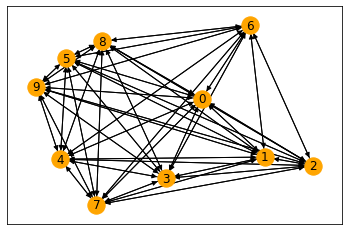

In [17]:
# show a graph of resulting network
G = nx.MultiDiGraph()

G.add_nodes_from(nodes_id)
for i, nodeFrom in enumerate(edges):
    for j, nodeTo in enumerate(nodeFrom):
        G.add_edge(i, j, travel_time=timeMatrix[i][j], energy_consumption=energyMatrix[i][j])

nx.draw_networkx(G, with_labels=True, pos=coordinates, node_color='orange')
plt.show()

In [18]:
G.edges()

OutMultiEdgeDataView([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)])